In [43]:
# -*- coding: utf-8 -*-
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt, numpy as np, pandas as pd
import fix_yahoo_finance as yf
from pandas import ExcelWriter
from pandas_datareader import data
import plotly
from plotly.graph_objs import *
from plotly import tools
plotly.offline.init_notebook_mode(connected=True)

In [34]:
start = datetime(2015, 1, 1)
all_data = {ticker: yf.download(ticker, start)
            for ticker in ['0700.HK', '^HSI', '0941.HK', '1398.HK']}

price = pd.DataFrame({ticker: data['Adj Close']
                     for ticker, data in all_data.items()})
volume = pd.DataFrame({ticker: data['Volume']
                      for ticker, data in all_data.items()})

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


          0700.HK   0941.HK   1398.HK      ^HSI
0700.HK  1.000000  0.442704  0.577075  0.771191
0941.HK  0.442704  1.000000  0.513818  0.685521
1398.HK  0.577075  0.513818  1.000000  0.836681
^HSI     0.771191  0.685521  0.836681  1.000000
          0700.HK   0941.HK   1398.HK      ^HSI
0700.HK  0.000306  0.000107  0.000155  0.000152
0941.HK  0.000107  0.000190  0.000109  0.000106
1398.HK  0.000155  0.000109  0.000235  0.000144
^HSI     0.000152  0.000106  0.000144  0.000126


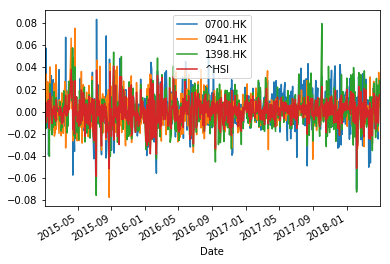

In [35]:
returns = price.pct_change()
print(returns.corr())
print(returns.cov())
returns.plot()
plt.show()

data.rolling -> calculating moving average (window = num of days)

In [36]:
for ticker in all_data.keys():
    data = all_data[ticker]['Close']
    all_data[ticker]['Ticks'] = range(0, len(all_data[ticker]))
    all_data[ticker]['short_rolling'] = data.rolling(window=10).mean()
    all_data[ticker]['long_rolling'] = data.rolling(window=30).mean()

this part is used to plot the closing price by MA

--static graph--

In [37]:
'''
for ticker in all_data.keys():
    data = all_data[ticker]    
    fig, ax = plt.subplots(figsize=(16,9))

    ax.plot(data.index, data.Close, label=ticker)
    ax.plot(data.index, data.short_rolling, label='10 days rolling')
    ax.plot(data.index, data.long_rolling, label='30 days rolling')

    ax.set_xlabel('Date')
    ax.set_ylabel('Adjusted closing price ($)')
    ax.legend()
'''

"\nfor ticker in all_data.keys():\n    data = all_data[ticker]    \n    fig, ax = plt.subplots(figsize=(16,9))\n\n    ax.plot(data.index, data.Close, label=ticker)\n    ax.plot(data.index, data.short_rolling, label='10 days rolling')\n    ax.plot(data.index, data.long_rolling, label='30 days rolling')\n\n    ax.set_xlabel('Date')\n    ax.set_ylabel('Adjusted closing price ($)')\n    ax.legend()\n"

this part is used to plot the closing price by MA
data.rolling -> calculating moving average (window = num of days)
dynamic graph

In [38]:

for ticker in all_data.keys():
    data = all_data[ticker]
    close = Scatter(x=data.index, y=data.Close, name='Close')
    short = Scatter(x=data.index, y=data.short_rolling, name='10 days rolling')
    long = Scatter(x=data.index, y=data.long_rolling, name='30 days rolling')
    plotly.offline.iplot({
        "data": Data([close, short, long]),
        "layout": Layout(title= ticker)
    })

# Perform Linear Regression

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [40]:
predict_dict = {}

for ticker in all_data.keys():
    data = all_data[ticker]
    sub_data = data.dropna()
    X = sub_data[['Ticks']]
    y = sub_data['long_rolling']
    model = LinearRegression()
    model.fit(X, y)
    m = model.coef_
    b = model.intercept_
    predictions = model.predict(X)
    predictions = pd.DataFrame(predictions, index = sub_data.index.values, columns = ['Pred'])
    joined_df = sub_data.join(predictions, how = 'inner')
    predict_dict.update({ticker :{'data_set': joined_df, 
                                  'intercept': round(b,2), 
                                  'coef': m}})    

In [41]:
for ticker in predict_dict.keys():
    data = predict_dict[ticker]['data_set']
    close = Scatter(x=data.index, y=data.Close, name='Close')
    long = Scatter(x=data.index, y=data.long_rolling, name='30 days rolling')
    pred = Scatter(x=data.index, y=data.Pred, name='Prediction')
    plotly.offline.iplot({
        "data": Data([close, long, pred]),
        "layout": Layout(title= ticker)
    })

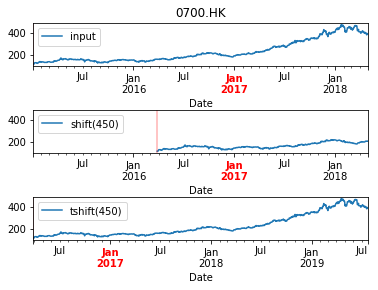

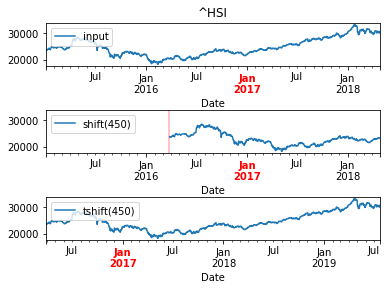

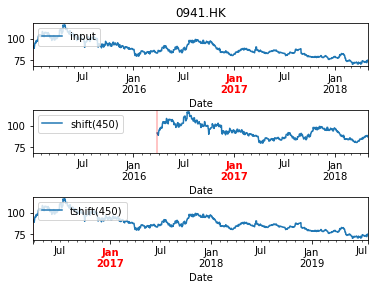

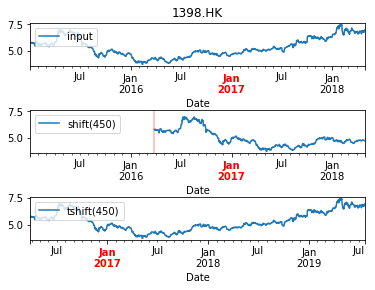

In [42]:
# apply a frequency to the data
for ticker in all_data.keys():
    data = all_data[ticker]['Close']
    
    fig, ax = plt.subplots(3, 1, sharey=True)
    data = data.asfreq('D', method='pad')

    data.plot(ax=ax[0])
    data.shift(450).plot(ax=ax[1])
    data.tshift(450).plot(ax=ax[2])

    # legends and annotations
    local_max = pd.to_datetime('2015-01-01')
    offset = pd.Timedelta(450, 'D')
    
    ax[0].legend(['input'], loc=2)
    ax[0].get_xticklabels()[2].set(weight='heavy', color='red')
    ax[0].axvline(local_max, alpha=0.3, color='red')

    ax[1].legend(['shift(450)'], loc=2)
    ax[1].get_xticklabels()[2].set(weight='heavy', color='red')
    ax[1].axvline(local_max + offset, alpha=0.3, color='red')

    ax[2].legend(['tshift(450)'], loc=2)
    ax[2].get_xticklabels()[1].set(weight='heavy', color='red')
    ax[2].axvline(local_max + offset, alpha=0.3, color='red')
    
    ax[0].set_title(ticker)
    plt.subplots_adjust(hspace = 1)

In [53]:
for ticker in all_data.keys():
    data = all_data[ticker]['Close']
    data = data.asfreq('D', method='pad')
    close = Scatter(x=data.index, y=data, name='Close')
    shift = Scatter(x=data.shift(450).index, y=data.shift(450), name='shift')
    tshift = Scatter(x=data.tshift(450).index, y=data.tshift(450), name='tshift')
    
    fig = tools.make_subplots(rows=3, cols=1)
    
    fig.append_trace(close, 1, 1)
    fig.append_trace(shift, 2, 1)
    fig.append_trace(tshift, 3, 1)
    
    fig['layout'].update(height=600, width=800, title = ticker)
    plotly.offline.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]

